In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -u "/content/drive/MyDrive/Computer Vision and Machine Learning for Medical Data Analysis/Module-10/Lecture 15/archive.zip" -d "/content/"
print('\n\ndone!')

Archive:  /content/drive/MyDrive/Computer Vision and Machine Learning for Medical Data Analysis/Module-10/Lecture 15/archive.zip
  inflating: /content/Dataset_BUSI_with_GT/benign/benign (1).png  
  inflating: /content/Dataset_BUSI_with_GT/benign/benign (1)_mask.png  
  inflating: /content/Dataset_BUSI_with_GT/benign/benign (10).png  
  inflating: /content/Dataset_BUSI_with_GT/benign/benign (10)_mask.png  
  inflating: /content/Dataset_BUSI_with_GT/benign/benign (100).png  
  inflating: /content/Dataset_BUSI_with_GT/benign/benign (100)_mask.png  
  inflating: /content/Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png  
  inflating: /content/Dataset_BUSI_with_GT/benign/benign (101).png  
  inflating: /content/Dataset_BUSI_with_GT/benign/benign (101)_mask.png  
  inflating: /content/Dataset_BUSI_with_GT/benign/benign (102).png  
  inflating: /content/Dataset_BUSI_with_GT/benign/benign (102)_mask.png  
  inflating: /content/Dataset_BUSI_with_GT/benign/benign (103).png  
  inflating: /con

##Pre-processing

In [3]:
import os
import shutil

folder_path = "/content/Dataset_BUSI_with_GT/normal"

# Check if folder exists before deleting
if os.path.exists(folder_path):
    shutil.rmtree(folder_path)
    print("Folder deleted successfully")
else:
    print("Folder does not exist")

Folder deleted successfully


In [5]:
import os
import shutil

# Define the source directory containing images
source_dir = "/content/Dataset_BUSI_with_GT/malignant"

# Define target directories
image_dir = os.path.join(source_dir, "images")
mask_dir = os.path.join(source_dir, "masks")

# Create target directories if they don't exist
os.makedirs(image_dir, exist_ok=True)
os.makedirs(mask_dir, exist_ok=True)

# Iterate through files in the source directory
for filename in os.listdir(source_dir):
    file_path = os.path.join(source_dir, filename)

    # Check if it's a file (not a directory)
    if os.path.isfile(file_path):
        if "mask" in filename.lower():  # Check if filename contains 'mask'
            shutil.move(file_path, os.path.join(mask_dir, filename))
        else:
            shutil.move(file_path, os.path.join(image_dir, filename))

print("Images and masks have been separated successfully!")


Images and masks have been separated successfully!


In [ ]:
!pip install keras_ocr

In [7]:
import cv2
import os
import numpy as np
#import keras_ocr

def resize_image(image, size=(224, 224)):
    return cv2.resize(image, size, interpolation=cv2.INTER_AREA)

'''def remove_text(image):
    try:
        pipeline = keras_ocr.pipeline.Pipeline()
        predictions = pipeline.recognize([image])
        mask = np.zeros(image.shape[:2], dtype=np.uint8)

        for text, box in predictions[0]:
            box = np.array(box, dtype=np.int32)
            cv2.fillPoly(mask, [box], (255, 255, 255))

        inpainted_image = cv2.inpaint(image, mask, inpaintRadius=3, flags=cv2.INPAINT_NS)
        return inpainted_image
    except ValueError as e:
        return image'''

def remove_artifacts(image):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

def remove_speckle_noise(image):
    return cv2.medianBlur(image, 3)

def preprocess_images(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(input_folder, filename)
            image = cv2.imread(img_path)

            resized = resize_image(image)
            #text_removed = remove_text(resized)
            artifacts_removed = remove_artifacts(resized)
            final_image = remove_speckle_noise(artifacts_removed)

            output_path = os.path.join(output_folder, filename)
            cv2.imwrite(output_path, final_image)
            print(f'Processed: {filename}')

# Example usage
input_folder = '/content/Dataset_BUSI_with_GT/benign/images'
output_folder = '/content/Dataset_BUSI_with_GT/benign/Processed_images'
preprocess_images(input_folder, output_folder)

Processed: benign (117).png
Processed: benign (210).png
Processed: benign (108).png
Processed: benign (189).png
Processed: benign (387).png
Processed: benign (414).png
Processed: benign (190).png
Processed: benign (175).png
Processed: benign (424).png
Processed: benign (107).png
Processed: benign (137).png
Processed: benign (344).png
Processed: benign (36).png
Processed: benign (291).png
Processed: benign (427).png
Processed: benign (363).png
Processed: benign (197).png
Processed: benign (380).png
Processed: benign (292).png
Processed: benign (314).png
Processed: benign (227).png
Processed: benign (141).png
Processed: benign (22).png
Processed: benign (383).png
Processed: benign (365).png
Processed: benign (124).png
Processed: benign (426).png
Processed: benign (188).png
Processed: benign (177).png
Processed: benign (122).png
Processed: benign (310).png
Processed: benign (97).png
Processed: benign (2).png
Processed: benign (73).png
Processed: benign (87).png
Processed: benign (257).png

##Marging Masks

In [12]:
import os

def count_files(folder_path):
    return len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])

folder_path = "/content/Dataset_BUSI_with_GT/benign/masks"
num_files = count_files(folder_path)
print(f"Number of files: {num_files}")


Number of files: 437


In [11]:
import cv2
import os
import numpy as np
from collections import defaultdict

def combine_masks(input_folder):
    # Dictionary to group mask files by base image name (without numbering suffix)
    masks_dict = defaultdict(list)

    # Scan folder and categorize files
    for filename in os.listdir(input_folder):
        if filename.endswith('.png') and '_mask' in filename:
            # Extract the base name before the first "_mask"
            base_name = filename.split('_mask')[0]
            masks_dict[base_name].append(filename)

    # Process only those that have more than one mask
    for base_name, mask_files in masks_dict.items():
        if len(mask_files) > 1:  # Ignore cases with a single mask
            combined_mask = None

            # Sort mask filenames to ensure correct processing order
            mask_files.sort()

            for mask_file in mask_files:
                mask_path = os.path.join(input_folder, mask_file)
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale

                if mask is None:
                    print(f"Warning: Could not read {mask_path}")
                    continue

                if combined_mask is None:
                    combined_mask = mask
                else:
                    # Combine masks using bitwise OR
                    combined_mask = cv2.bitwise_or(combined_mask, mask)

            # Save the combined mask (replacing originals)
            output_filename = f"{base_name}_combined_mask.png"
            output_path = os.path.join(input_folder, output_filename)
            cv2.imwrite(output_path, combined_mask)
            print(f'Combined mask saved: {output_path}')

            # Remove original mask files
            for mask_file in mask_files:
                mask_path = os.path.join(input_folder, mask_file)
                os.remove(mask_path)
                print(f'Deleted: {mask_path}')

# Example usage
input_folder = '/content/Dataset_BUSI_with_GT/benign/masks'
combine_masks(input_folder)

Combined mask saved: /content/Dataset_BUSI_with_GT/benign/masks/benign (424)_combined_mask.png
Deleted: /content/Dataset_BUSI_with_GT/benign/masks/benign (424)_mask.png
Deleted: /content/Dataset_BUSI_with_GT/benign/masks/benign (424)_mask_1.png
Combined mask saved: /content/Dataset_BUSI_with_GT/benign/masks/benign (346)_combined_mask.png
Deleted: /content/Dataset_BUSI_with_GT/benign/masks/benign (346)_mask.png
Deleted: /content/Dataset_BUSI_with_GT/benign/masks/benign (346)_mask_1.png
Combined mask saved: /content/Dataset_BUSI_with_GT/benign/masks/benign (195)_combined_mask.png
Deleted: /content/Dataset_BUSI_with_GT/benign/masks/benign (195)_mask.png
Deleted: /content/Dataset_BUSI_with_GT/benign/masks/benign (195)_mask_1.png
Deleted: /content/Dataset_BUSI_with_GT/benign/masks/benign (195)_mask_2.png
Combined mask saved: /content/Dataset_BUSI_with_GT/benign/masks/benign (83)_combined_mask.png
Deleted: /content/Dataset_BUSI_with_GT/benign/masks/benign (83)_mask.png
Deleted: /content/Data

##Save the final dataset

In [13]:
import os
import shutil

benign = "/content/Dataset_BUSI_with_GT/benign/images"
malignant = '/content/Dataset_BUSI_with_GT/malignant/images'
# Check if folder exists before deleting
if os.path.exists(benign):
    shutil.rmtree(benign)
    print("Benign deleted successfully")
else:
    print("Benign does not exist")


if os.path.exists(malignant):
    shutil.rmtree(malignant)
    print("Malignant Folder deleted successfully")
else:
    print("Malignant does not exist")

Benign deleted successfully
Malignant Folder deleted successfully


Final dataset zip

In [14]:
import shutil

def zip_folder(folder_path, output_zip):
    shutil.make_archive(output_zip, 'zip', folder_path)
    print(f'Folder zipped: {output_zip}.zip')

# Example usage
folder_to_zip = '/content/Dataset_BUSI_with_GT'  # Folder to be zipped
output_zip_path = '/content/Final_dataset'  # Output zip file (without .zip)
zip_folder(folder_to_zip, output_zip_path)

Folder zipped: /content/Final_dataset.zip


##Segmentation on the processed dataset

In [15]:
## Making essential imports
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

In [16]:
import os

def rename_files(directory):
    for filename in os.listdir(directory):
        new_name = filename.replace("_mask", "").replace("_combined", "")
        old_path = os.path.join(directory, filename)
        new_path = os.path.join(directory, new_name)

        if old_path != new_path:
            os.rename(old_path, new_path)
            print(f'Renamed: {filename} -> {new_name}')

# Example usage
directory = "/content/Dataset_BUSI_with_GT/benign/masks"  # Change this to your target directory
rename_files(directory)


Renamed: benign (308)_mask.png -> benign (308).png
Renamed: benign (337)_mask.png -> benign (337).png
Renamed: benign (257)_mask.png -> benign (257).png
Renamed: benign (336)_mask.png -> benign (336).png
Renamed: benign (113)_mask.png -> benign (113).png
Renamed: benign (158)_mask.png -> benign (158).png
Renamed: benign (186)_mask.png -> benign (186).png
Renamed: benign (435)_mask.png -> benign (435).png
Renamed: benign (379)_mask.png -> benign (379).png
Renamed: benign (352)_mask.png -> benign (352).png
Renamed: benign (350)_mask.png -> benign (350).png
Renamed: benign (97)_mask.png -> benign (97).png
Renamed: benign (244)_mask.png -> benign (244).png
Renamed: benign (330)_mask.png -> benign (330).png
Renamed: benign (342)_mask.png -> benign (342).png
Renamed: benign (300)_mask.png -> benign (300).png
Renamed: benign (18)_mask.png -> benign (18).png
Renamed: benign (17)_mask.png -> benign (17).png
Renamed: benign (363)_mask.png -> benign (363).png
Renamed: benign (307)_mask.png -> ben

In [17]:
framObjTrain = {'img': [],
                'mask': []
               }

def LoadData(frameObj=None, imgPath=None, maskPath=None, shape=128):
    imgNames = os.listdir(imgPath)

    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'

    for imgName in imgNames:
        # Check if the file is an image file
        if imgName.endswith('.png'):
            img = plt.imread(imgAddr + imgName)
            maskName = imgName.split('.png')[0] + '.png'
            mask = plt.imread(maskAddr + maskName)

            img = cv2.resize(img, (shape, shape))
            mask = cv2.resize(mask, (shape, shape))

            frameObj['img'].append(img)
            frameObj['mask'].append(mask)

    return frameObj

In [19]:
# loading benign samples

framObjTrain = LoadData( framObjTrain, imgPath = '/content/Dataset_BUSI_with_GT/benign/Processed_images'
                        , maskPath = '/content/Dataset_BUSI_with_GT/benign/masks'
                         , shape = 128)

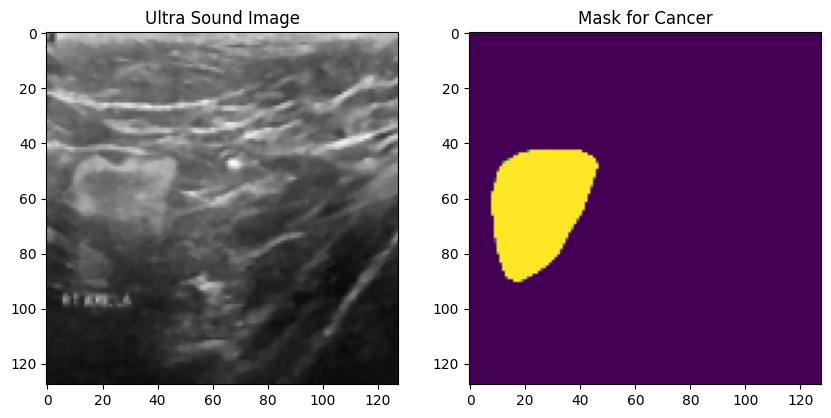

In [20]:
## displaying data loaded by our function
plt.figure(figsize = (10, 7))
plt.subplot(1,2,1)
plt.imshow(framObjTrain['img'][1])
plt.title('Ultra Sound Image')
plt.subplot(1,2,2)
plt.imshow(framObjTrain['mask'][1])
plt.title('Mask for Cancer')
plt.show()

In [21]:
pip install superml

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(framObjTrain['img'], framObjTrain['mask'], test_size = 0.30, random_state = 42)

In [23]:
import tensorflow as tf
from tensorflow.keras import layers

# Channel Self-Attention
class ChannelAttention(tf.keras.layers.Layer):
    def __init__(self, in_planes, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = layers.GlobalAveragePooling2D()
        self.fc1 = layers.Dense(in_planes // reduction_ratio, activation='relu', use_bias=False)
        self.fc2 = layers.Dense(in_planes, activation='sigmoid', use_bias=False)

    def call(self, x):
        avg_out = self.avg_pool(x)
        avg_out = self.fc1(avg_out)
        avg_out = self.fc2(avg_out)
        return tf.expand_dims(tf.expand_dims(avg_out, axis=1), axis=1) * x

# Partial (Spatial) Attention
class PartialAttention(tf.keras.layers.Layer):
    def __init__(self, in_planes):
        super(PartialAttention, self).__init__()
        self.conv1 = layers.Conv2D(in_planes // 8, kernel_size=1, activation='relu')
        self.conv2 = layers.Conv2D(in_planes, kernel_size=1, activation='sigmoid')

    def call(self, x):
        attention_map = self.conv1(x)
        attention_map = self.conv2(attention_map)
        return x * attention_map

# Conv2D Block with Attention
def Conv2dBlock(inputTensor, numFilters, kernelSize=3, doBatchNorm=True):
    x = layers.Conv2D(filters=numFilters, kernel_size=(kernelSize, kernelSize),
                      kernel_initializer='he_normal', padding='same')(inputTensor)
    if doBatchNorm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters=numFilters, kernel_size=(kernelSize, kernelSize),
                      kernel_initializer='he_normal', padding='same')(x)
    if doBatchNorm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Apply Channel Attention
    x = ChannelAttention(numFilters)(x)

    # Apply Partial Attention
    x = PartialAttention(numFilters)(x)

    return x


In [24]:
def GiveMeUnet(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)

    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)

    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)

    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)

    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)

    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)

    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)

    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)

    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)

    output = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model

Model Instantiation

In [25]:
batch_size = 128
inputs = tf.keras.layers.Input((128, 128, 3))
rkoshaheds_model = GiveMeUnet(inputs, droupouts= 0.3)
rkoshaheds_model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )
rkoshaheds_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ activation[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ channel_attention   │ (None, 128, 128,  │         32 │ activation_1[0][… │
│ (ChannelAttention)  │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ partial_attention   │ (None, 128, 128,  │         82 │ channel_attentio… │
│ (PartialAttention)  │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ partial_attentio… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 64,    │          0 │ max_pooling2d[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │      4,640 │ dropout[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │      9,248 │ activation_2[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 64,    │          0 │ batch_normalizat

 Total params: 2,206,317 (8.42 MB)

 Trainable params: 2,203,373 (8.41 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [26]:
hisVal = rkoshaheds_model.fit(np.array(X_train), np.array(y_train), batch_size = batch_size, epochs = 1)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


3/3 ━━━━━━━━━━━━━━━━━━━━ 113s 24s/step - accuracy: 0.7741 - loss: 0.6166


In [ ]:
retVal = rkoshaheds_model.fit(np.array(X_test), np.array(y_test), epochs = 1)

In [ ]:
#Saving Model
rkoshaheds_model.save('New BreastCancerSegmentor.h5')

##Generate mask from trained model

In [28]:
import os
import cv2
import numpy as np
import random
from tensorflow.keras.models import load_model

# Load the UNet model
model = load_model('/content/model (1).h5')  # Change path as needed

# Define the input and output folders
input_folder = '/content/Dataset_BUSI_with_GT/benign/Processed_images/'
output_folder = '/content/segmented/'

# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)

# Get all image filenames in the input folder
image_filenames = [filename for filename in os.listdir(input_folder) if filename.endswith((".png", ".jpg"))]

# Randomly select 10 images
selected_images = random.sample(image_filenames, 10)

# Process the selected images
for filename in selected_images:
    # Read and preprocess the image
    image_path = os.path.join(input_folder, filename)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
    image = cv2.resize(image, (256, 256))  # Resize to model input size (256, 256)
    image = np.repeat(image[..., np.newaxis], 3, axis=-1) / 255.0  # Convert grayscale to RGB and normalize

    # Predict and save the segmented image
    segmented_image = model.predict(np.expand_dims(image, axis=0))[0, :, :, 0]  # Prediction and segmentation
    cv2.imwrite(os.path.join(output_folder, filename), (segmented_image > 0.5).astype(np.uint8) * 255)  # Save

    print(f"Saved segmented image: {filename}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 930ms/step
Saved segmented image: benign (70).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
Saved segmented image: benign (268).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Saved segmented image: benign (82).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
Saved segmented image: benign (106).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Saved segmented image: benign (180).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
Saved segmented image: benign (204).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
Saved segmented image: benign (213).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
Saved segmented image: benign (222).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
Saved segmented image: benign (138).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
Saved segmented image: benign (383).png


##Create classification dataset

In [33]:
import os
import cv2
import numpy as np

# Define the image and mask folders
image_folder = '/content/Dataset_BUSI_with_GT/malignant/Processed_images'  # Image folder path
mask_folder = '/content/Dataset_BUSI_with_GT/malignant/masks'  # Mask folder path
output_folder = '/content/Classification_dataset/benign'  # Folder to save the results

# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)

# Get all image filenames in the image folder
image_filenames = [filename for filename in os.listdir(image_folder) if filename.endswith((".png", ".jpg"))]

def resize_image(image, size=(224, 224)):
    return cv2.resize(image, size, interpolation=cv2.INTER_AREA)

# Process all images in the image folder
for filename in image_filenames:
    # Construct the paths for the image and mask
    image_path = os.path.join(image_folder, filename)
    mask_path = os.path.join(mask_folder, filename)

    # Check if corresponding mask exists
    if os.path.exists(mask_path):
        # Read the image and mask
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
        resize_image(image)
        resize_image(mask)

        # Resize the image and mask
        image = resize_image(image)
        mask = resize_image(mask)
        # Ensure the mask is binary (0 or 255)
        mask = (mask > 0).astype(np.uint8) * 255

        # Perform bitwise AND between the image and mask
        result = cv2.bitwise_and(image, mask)

        # Save the resulting image
        output_path = os.path.join(output_folder, filename)
        cv2.imwrite(output_path, result)

        print(f"Saved bitwise AND result: {output_path}")
    else:
        print(f"No corresponding mask found for {filename}")


No corresponding mask found for malignant (136).png
No corresponding mask found for malignant (60).png
No corresponding mask found for malignant (65).png
No corresponding mask found for malignant (42).png
No corresponding mask found for malignant (67).png
No corresponding mask found for malignant (95).png
No corresponding mask found for malignant (141).png
No corresponding mask found for malignant (78).png
No corresponding mask found for malignant (26).png
No corresponding mask found for malignant (94).png
No corresponding mask found for malignant (168).png
No corresponding mask found for malignant (97).png
No corresponding mask found for malignant (148).png
No corresponding mask found for malignant (149).png
No corresponding mask found for malignant (113).png
No corresponding mask found for malignant (70).png
No corresponding mask found for malignant (31).png
No corresponding mask found for malignant (163).png
No corresponding mask found for malignant (12).png
No corresponding mask fo

##Classification

In [ ]:
import cv2
import numpy as np
import glob
import os

In [ ]:
pip install split-folders

In [ ]:
import splitfolders
import os

input_folder="/content/Classification_dataset"

output="/content/op"

splitfolders.ratio(input_folder, output, seed=42, ratio=(0.70,0.15,0.15)) ### train 75%, val 15%, test 10%

Copying files: 647 files [00:00, 1500.79 files/s]


Import libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import BatchNormalization, LSTM, GlobalAveragePooling1D, MaxPooling2D, ZeroPadding2D, Conv2D, GlobalAveragePooling2D, Dense, Flatten, Concatenate, Reshape
import matplotlib.pyplot as plt
#transfer learning model

#import various transfer elarning models
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import DenseNet201

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob

import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
import tensorflow as tf


Model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def RkoNet13(input_shape=(None, None, 3)):
    model = models.Sequential()

    # Block 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    # Block 2
    model.add(layers.Conv2D(64, (5, 5), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Block 3
    model.add(layers.Conv2D(64, (5, 5), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Block 4
    model.add(layers.Conv2D(128, (5, 5), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Block 5
    model.add(layers.Conv2D(256, (5, 5), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Fully Connected Layers
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(2, activation='sigmoid'))  # Assuming binary classification

    return model

# Create and compile the model
model = RkoNet13(input_shape=(224, 224, 3))  # Example input shape
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 112, 112, 64)        │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 56, 56, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 28, 28, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 14, 14, 256)         │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 512)                 │       6,423,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,733,890 (29.50 MB)

 Trainable params: 7,733,890 (29.50 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
### image datagenerator
train_datagen = ImageDataGenerator(
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('/content/op/train',
                                                 target_size = (224,224),
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

val_set = val_datagen.flow_from_directory('/content/op/val',
                                            target_size = (224,224),
                                            batch_size = 16,
                                            class_mode = 'categorical')

test_datagen = ImageDataGenerator(rescale = 1./255)

test_set = test_datagen.flow_from_directory('/content/op/test',
                                            target_size = (224,224),
                                            batch_size = 16,
                                            class_mode = 'categorical')

Found 452 images belonging to 2 classes.
Found 96 images belonging to 2 classes.
Found 99 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

# Define the correct filepath ending in `.weights.h5`
filepath = "/content/rko.weights.h5"

# Define the ModelCheckpoint
checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,
                               save_weights_only=True, save_best_only=False, mode='max')

# Define the CSVLogger
log_csv = CSVLogger('/content/rko.csv', separator=',', append=False)


# List of callbacks
callbacks_list = [checkpoint1, log_csv]

steps_per_epoch = len(training_set)
validation_steps = len(val_set)

r = model.fit(
    training_set,
    epochs=2,
    validation_data=val_set,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks_list
)

Epoch 1/2
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5280 - loss: 3.1919
Epoch 1: saving model to /content/rko.weights.h5
29/29 ━━━━━━━━━━━━━━━━━━━━ 130s 4s/step - accuracy: 0.5311 - loss: 3.1368 - val_accuracy: 0.6771 - val_loss: 0.6813
Epoch 2/2
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6794 - loss: 0.6434
Epoch 2: saving model to /content/rko.weights.h5
29/29 ━━━━━━━━━━━━━━━━━━━━ 127s 4s/step - accuracy: 0.6797 - loss: 0.6429 - val_accuracy: 0.6771 - val_loss: 0.6636
